In [4]:
import pandas as pd

scores = pd.read_csv("Restaurant_Scores_-_LIVES_Standard.csv")

print(len(scores.columns))
print(scores.columns)
#print(scores)

17
Index(['business_id', 'business_name', 'business_address', 'business_city',
       'business_state', 'business_postal_code', 'business_latitude',
       'business_longitude', 'business_location', 'business_phone_number',
       'inspection_id', 'inspection_date', 'inspection_score',
       'inspection_type', 'violation_id', 'violation_description',
       'risk_category'],
      dtype='object')


In [5]:
num_businesses = len(scores.business_id.unique())
num_inspections = len(scores.inspection_id.unique())

print("This data set contains", num_inspections, "inspections of", num_businesses, "businesses." )

This data set contains 25876 inspections of 6080 businesses.


In [6]:
#for now, drop rows with missing data
print('Original length:', len(scores))
scores = scores.dropna(subset=['inspection_score', 'business_latitude', 'business_longitude' ])
#for now, drop rows with 0 for lattitude (missing data)
#later, convert addresses to lat, long
scores = scores[scores.business_latitude > 37.7] #drop any point not in SF proper
scores = scores[scores.business_longitude < -122.375] #drop any point not in SF proper
print('New length:', len(scores))

Original length: 53729
New length: 29262


In [7]:
import numpy as np
scores_dedup = scores.groupby('inspection_id').mean()
score_change = []
for i in range(len(scores_dedup.index) - 1):
    if scores_dedup.business_id[i] == scores_dedup.business_id[i + 1]:
        score_diff = scores_dedup.inspection_score[i + 1] - scores_dedup.inspection_score[i]
        #grouping by inspection id and taking mean removed date - fix later
        #date_diff = scores_dedup.inspection_date[i + 1] - scores_dedup.inspection_date[i] 
        score_change.append([scores_dedup.inspection_score[i], score_diff])
score_change = np.array(score_change)

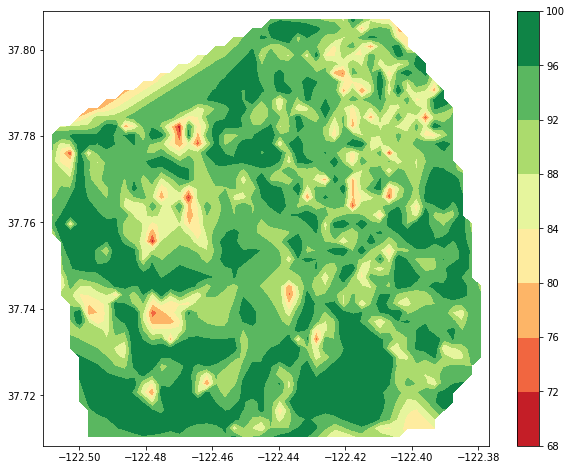

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata

def grid(x, y, z, resX=50, resY=50):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

X, Y, Z = grid(scores_dedup.business_longitude, scores_dedup.business_latitude, scores_dedup.inspection_score)

plt.figure(figsize=(10,8))
plt.contourf(X, Y, Z, cmap='RdYlGn')
plt.colorbar()
plt.show()

There are two interesting results that I have already gleaned from the data that indicate that there is more to learn from the data. First, looking at a contour plot of the scores over latitude and longitude, there seem to be areas that over and under perform (eg downtown and the Sunset district underperform). This could benefit from further analysis of the dates of the scores to look at seasonality or even spot problem that suddenly appears in a localized area (eg rats).  Furthermore, adding Yelp Challenge data could allow improved analysis as to what types of restaurants perform well or underperform.

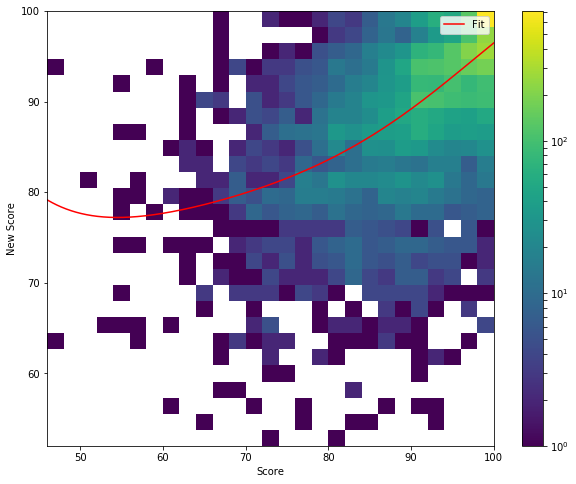

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm

poly_model = make_pipeline(PolynomialFeatures(5),
                           LinearRegression())

poly_model.fit(score_change[:, 0, np.newaxis], score_change[:,1] + score_change[:, 0])

xfit = np.linspace(40, 100, 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

#plt.scatter(score_change[:,0], score_change[:,1])
plt.figure(figsize=(10,8))
plt.hist2d(score_change[:,0], score_change[:,1] + score_change[:, 0], bins=27, norm=LogNorm(), cmap='viridis')
plt.colorbar()
plt.xlabel("Score")
plt.ylabel("New Score")
regression_fit, = plt.plot(xfit, yfit, c='red', label='Fit')
plt.legend(handles=[regression_fit])

The second interesting insight is that no matter how bad the previous score was, the next score, on average, is brought up into the high 70s. If a health score of 70 is too low for your liking (it is for mine), there is a fairly linear relationship in the scores from around 80 to 100. If a score was good, it is likely to remain around the same value. That means if you really want a pristine experience (~100), you may not even want to gamble on a decently scoring restaurant (~80). 

In [10]:
scores.risk_category.unique()
X = []
y = []

category_labels = ['Low Risk', 'Moderate Risk', 'High Risk']

for i in scores.risk_category.index:
    #print(scores.risk_category[i])
    if ( scores.risk_category[i] == 'Low Risk'):
        X.append(scores.violation_description[i])
        y.append(0)
    elif ( scores.risk_category[i] == 'Moderate Risk'):
        X.append(scores.violation_description[i])
        y.append(1)
    elif ( scores.risk_category[i] == 'High Risk'):
        X.append(scores.violation_description[i])
        y.append(2)
y = np.array(y)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
#model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
def predict_category(s, train=X_train, model=model):
    pred = model.predict([s])
    return category_labels[pred[0]]

In [17]:
predict_category('unclean walls')

'Low Risk'

In [15]:
predict_category('not sanitized food contact surfaces')

'Moderate Risk'

In [16]:
predict_category('food stored at wrong temperature')

'High Risk'